## Задача 1:

Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления 
фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен 
A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая 
механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать 
новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то 
объясните, с чем они могут быть связаны и являются ли значимыми.

Данные:

active_users – информация о пользователях, которые посещали приложение во время эксперимента. 
groups – разбивка пользователей на контрольную (А) и тестовую (В) группы. 
purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента 

#### Алгоритм решения:

1.  Импортирую библиотеки.
2.  Загружаю датасеты.
3.  Смотрю структуру, типы данных, проверяю на наличие дубликатов и пропущенных значений.
4.  Формирую рабочий датафрейм из загруженных датасетов.
5.  Провожу разделение датасета на тестовую и контрольную группы.
6.  Анализирую базовый сценарий (при слиянии активных посетителей с купившими 149 купивших человек 
    оказываются без информации о стране, платформе и поле).
7.  Выбираю параметры для оценки АВ-теста.
8.  Проверяю насколько изменились основные параметры в тестовой группе относительно контрольной           группы.
9.  Строю боксплоты для того чтобы оценить выбросы.
10. Оцениваю наличие и величину выбросов и принимаю решение что с ними делать.
11. Проверяю тестовую и контрольную выборки на нормальность.
12. Проверяю равномерность распределения данных в контрольной и тестовой группах.
13. Выбираю метод проверки статистической значимости.
14. Осуществляю проверку на статистическую значимость. 
15. Делаю выводы.
16. Advanced сценарий 1 - проверяю на стат. значимость изменения, полученные в результате АВ-теста       по странам чтобы убедиться в том, что новую модель можно раскатывать на всех пользователей.
17. Advanced сценарий 2 - заполняю пропущенные значения после merge-а датасетов active_users и           purchases при помощи модели линейной регрессии или при помощи корреляционной формулы учитывая         выcокую корреляцию признаков с целевым параметром revenue (до этого момента я могу проверить         гипотезу (п. 16) на частичых данных - без информации о стране пользователей 149 аккаунтах).
17. Осуществляю проверку на статистическую значимость.
18. Делаю финальные выводы.

#### Импортирую библиотеки:

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import warnings

from scipy.stats import levene
from scipy.stats import shapiro

# часть импортирую для использования Бутстрепа:
    
import numpy as np
import scipy
import seaborn as sns

from scipy.stats import norm, mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
# from locale import atof, setlocale, LC_NUMERIC
import locale
from locale import atof
from tqdm.auto import tqdm

plt.style.use('ggplot')

# Загружаю датасеты:

purchases = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/zWzR0qsiYlnF0g')
                        
active_users = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/ozmQfT5Mc-vtoQ')
                        
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/G7kgh-Pp7bx5Fw')

#### Создаю функцию для сравнения shape датафреймов и наличия дубликатов в колонках:

In [2]:
def datasets_params(df1, df2, df3):
    
    params = {'purchases': ['shape', df1.shape, 'duplicated', df1.duplicated().sum()], 
              'active_users': ['shape', df2.shape, 'duplicated', df2.duplicated().sum()],
              'groups': ['shape', df3.shape, 'duplicated', df3.duplicated().sum()]
              }
 
    return print(pd.DataFrame(params))

datasets_params(purchases, active_users, groups)

    purchases active_users      groups
0       shape        shape       shape
1    (541, 2)    (8341, 4)  (74576, 2)
2  duplicated   duplicated  duplicated
3           0            0           0


#### Создаю функцию, которая мерджит исходные датафреймы:

In [3]:
def merge(df1, df2, df3):
    
    # Делаю outer join active_users и purchases. 
    
    # Считаю что для цели исследования наиболее важными показателями является не общее количество 
    # пользователей, а именно активные и совершившие покупку, поэтому делаю inner join c groups:
    
    df = (df1.merge(df2, on='user_id', how='outer')).merge(df3, on='user_id', how='inner')
    
    return df

df = merge(active_users, purchases, groups)

df.head()

,user_id,country,platform,sex,revenue,group
0,8029,Russia,ios,male,NaN,B
1,1735,Sweden,ios,male,NaN,B
2,7697,Russia,android,male,NaN,B
3,1421,Sweden,android,female,NaN,B
4,1704,Russia,ios,male,NaN,B


#### Произвожу разделение на тестовую и контрольную группы (только активных и купивших пользователей):

In [4]:
df_control = df.query('group == "A"')

df_test = df.query('group == "B"')

#### Создаю функцию для наглядной оценки изменения основных параметров в контрольной и тестовой группах

In [55]:
def before_after_params(df1, df2):
    
    Paying_conversion = (100 * df1.agg({'revenue': 'count'})/df1.shape[0]).item()
    Revenue = df1.revenue.sum()
    Revenue_mean = df1.revenue.mean()
    Revenue_median = df1.revenue.median()
    ARPU = df1.revenue.sum()/df1.user_id.nunique()
    AOV = df1.revenue.sum()/df1.agg({'revenue': 'count'}).item()
    all_clients = groups.query('group == "A"').shape[0]
    active_users = df1.shape[0]
    paying_users = df1.agg({'revenue': 'count'}).item()
    
    Paying_conversion1 = (100* df2.agg({'revenue': 'count'})/df2.shape[0]).item()
    Revenue1 = df2.revenue.sum()
    Revenue_mean1 = df2.revenue.mean()
    Revenue_median1 = df2.revenue.median()
    ARPU1 =  df2.revenue.sum()/df2.user_id.nunique()
    AOV1 = df2.revenue.sum()/df2.agg({'revenue': 'count'}).item()
    all_clients1 = groups.query('group == "B"').shape[0]
    active_users1 = df2.shape[0]
    paying_users1 = df2.agg({'revenue': 'count'}).item()



    outcomes = {'Control': ['Paying conversion', Paying_conversion, 'Revenue', Revenue, 
                            'ARPU', ARPU, 'AOV', AOV, 'num_users', all_clients, 
                            'active users', active_users, 'Revenue mean', Revenue_mean, 
                            'Revenue median', Revenue_median, 'Paying users', paying_users], 
                'Test': ['Paying conversion', Paying_conversion, 'Revenue', Revenue1, 
                         'ARPU', ARPU1, 'AOV', AOV1, 'num_users', all_clients1, 
                         'active users', active_users1, 'Revenue mean', Revenue_mean1, 
                         'Revenue median', Revenue_median1, 'Paying users', paying_users1],
                'Difference': ['Paying conversion difference', Paying_conversion1 - Paying_conversion, 
                               'Revenue difference', Revenue1 - Revenue, 'ARPU difference', ARPU1 - ARPU, 
                               'AOV difference', AOV1 - AOV, 'Difference in number of users', all_clients1 - all_clients, 
                               'Active users difference', active_users1 - active_users,
                               'Revenue_mean_difference', Revenue_mean1 - Revenue_mean,
                               'Revenue_median_difference', Revenue_median1 - Revenue_median,
                               'Paying users difference', paying_users1 - paying_users]
               }
 
    return print(pd.DataFrame(outcomes))

# Отключаю здесь не критичные предупреждения от Jupyter чтобы легче было читать результаты.

warnings.filterwarnings('ignore')

# Смотрю насколько изменились важные параметры в тестовой и контрольной группах:
 
    return print(pd.DataFrame(outcomes))

# Отключаю здесь не критичные предупреждения от Jupyter чтобы легче было читать результаты.

warnings.filterwarnings('ignore')

# Смотрю насколько изменились важные параметры в тестовой и контрольной группах:

before_after_params(df_control, df_test)

              Control               Test                     Difference
0   Paying conversion  Paying conversion   Paying conversion difference
1             6.82833            6.82833                      -0.559376
2             Revenue            Revenue             Revenue difference
3               93162             485575                         392413
4                ARPU               ARPU                ARPU difference
5             59.4525            70.1394                        10.6869
6                 AOV                AOV        Revenue_mean_difference
7             870.673            1118.84                        248.164
8           num_users          num_users      Revenue_median_difference
9               14693              59883                            246
10       active users       active users                 AOV difference
11               1567               6923                        248.164
12       Revenue mean       Revenue mean  Difference in number o

#### Выводы:

Насколько я понял задачу - исследуются клиенты из имеющейся клиентской базы (все пользователи о которых до начала 
эксперимента было известно изначально разделены на 2 группы в файле groups и часть из них в течение тестового периода 
пользовалась Приложением, часть его приобрела, новые уникальные пользователи в ходе эксперимента не появились).

Из сравнения параметров тестовой и контрольной выборок и смены модели оплаты коллекций шаблонов в тестовой группе на новую, можно сделать предварительные выводы о том, что в результате:
    
на 0.6% снизилась конверсия активных клиентов в покупку;
revenue увеличилась на 392 413 у.е.;
ARPU вырос на 10.7 у.е.;
AOV вырос на 248.1 у.е.

При этом важно учитывать, что в тестовой группе по сравнению в с контрольной оказалось
на 5356 больше пользователей;
на 327 возросло количество покупателей.

#### Строю боксплоты чтобы оценить наличие выбросов в контрольной и тестовой группах:

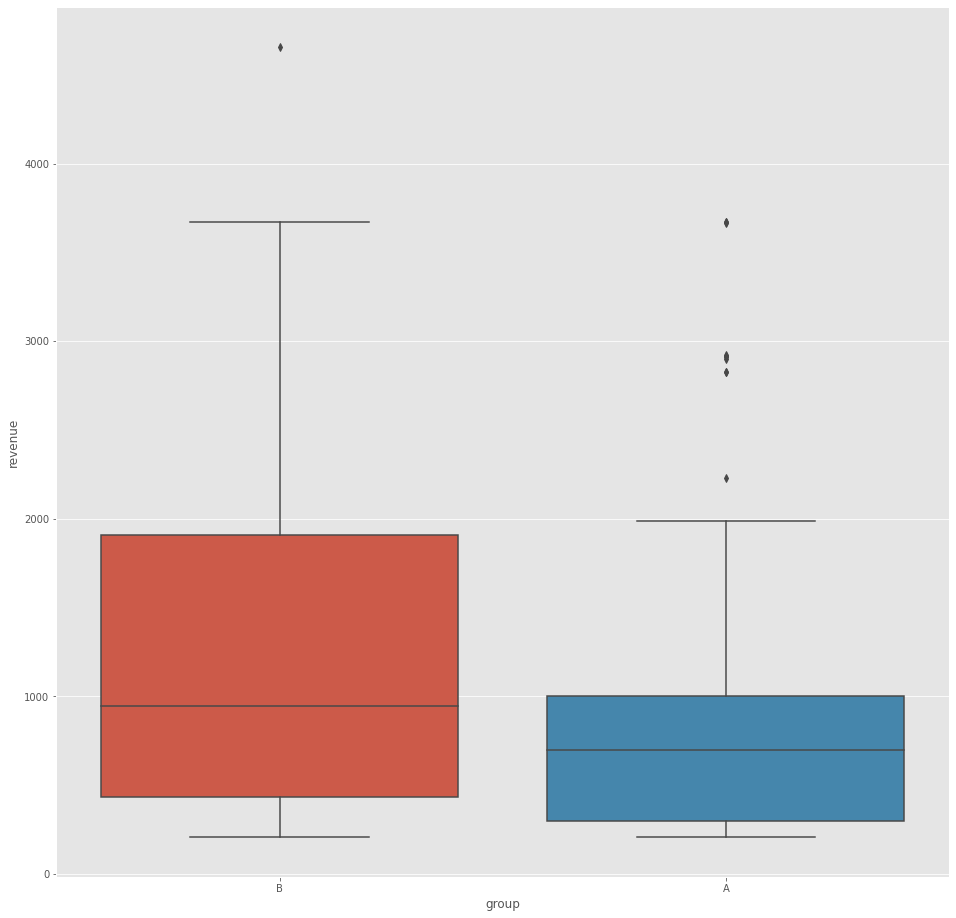

In [6]:
plt.figure(figsize=(16,16))

sns.boxplot(x='group', y ='revenue', data=df)

##### Вывод: И в тестовой и в контрольной группах есть сильные выбросы. Выберу именно эти данные и постараюсь понять причину их возникновения.

#### Создаю функцию, считающую межквартильный размах:

In [7]:
def iqr_interval(serie1, serie2):
        
    # Считаю верхний и нижний перцентили:
    
    q1_control = np.nanpercentile(df_control.revenue, 25)    
    q3_control = np.nanpercentile(df_control.revenue, 75)

    q1_test = np.nanpercentile(df_test.revenue, 25)    
    q3_test = np.nanpercentile(df_test.revenue, 75)


    iqr_control = q3_control - q1_control
    iqr_test = q3_test - q1_test
    
    
    return iqr_control, iqr_test, q3_control, q3_test

# Записываю результат работы функции в переменную:

interval = iqr_interval(df_control.revenue, df_test.revenue)

# Смотрю на выбросы, определенные по правилу межквартильного размаха в контрольной группе:

upper = df_control.query('revenue >= (@interval[2] + 1.5 * @interval[0])')

upper.sort_values('country')

,user_id,country,platform,sex,revenue,group
1175,3674,Russia,ios,female,2229.0,A
5445,2206,Russia,android,female,2910.0,A
5671,8025,Russia,ios,female,2921.0,A
8243,7950,Russia,ios,male,3669.0,A
429,1673,Sweden,android,male,2899.0,A
1082,3481,Sweden,android,male,2829.0,A
1988,591,Sweden,ios,female,3670.0,A
2517,392,Sweden,android,male,2920.0,A
2856,2093,Sweden,android,male,2828.0,A
4121,1606,Sweden,android,male,3671.0,A


#### Смотрю на выбросы, определенные по правилу межквартильного размаха в тестовой группе:

In [9]:
upper = df_test.query('revenue >= (@interval[3] + 1.5 * @interval[1])')

upper.sort_values('country')

,user_id,country,platform,sex,revenue,group
7286,3988,Sweden,ios,female,4660.0,B


#### Выводы:

в тестовой группе есть 1 явный выброс. Возможно, это корпоративный клиент, или администратор инстаграмм, под акаунтом которого работает группа администраторов, ведущие несколько каналов и обрабатывающих очень большое количество контента (в случае если Приложение чарджит за количество обрабатываемого контента);

возможно, это баг системы - нужно лучше понимать специфику бизнеса, запросить логи в Службе Поддержки.

В контрольной группе есть 10 выбросов. Вероятно их можно объяснить теми же причинами.

#### Выбираю оптимальный способ для проверки статистической значимости результатов АВ-теста. Смотрю график распределения в контрольной и тестовой группах:

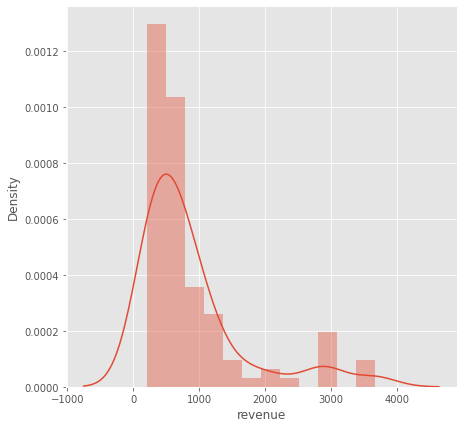

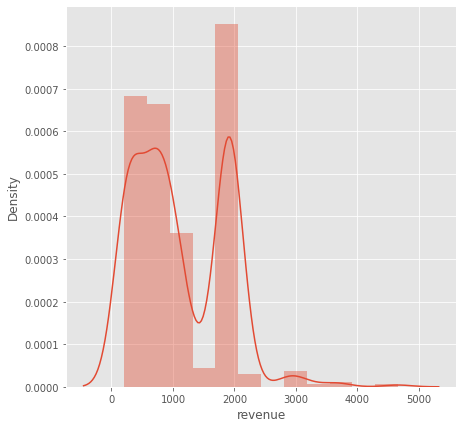

In [8]:
plt.figure(figsize=(7,7))
sns.distplot(df_control.revenue)

plt.figure(figsize=(7,7))
sns.distplot(df_test.revenue)

#### Создам копию датасетов но без этих выбросов:

In [47]:
l = [1175, 5445, 5671, 8243, 429, 1082, 1988, 2517, 2856, 4121]

control_t = df_control.query('user_id not in @l')

test_t = df_test.query('user_id != 3988')

#### Смотрю насколько изменились основные метрики в контрольной и тестовой группах после удаления явных выбросов:

In [51]:
before_after_params(control_t, test_t)

              Control               Test                     Difference
0   Paying conversion  Paying conversion   Paying conversion difference
1             6.83706            6.83706                      -0.581643
2             Revenue            Revenue             Revenue difference
3               93162             480915                         387753
4                ARPU               ARPU                ARPU difference
5             59.5284            69.4763                        9.94787
6                 AOV                AOV                 AOV difference
7             870.673            1110.66                        239.985
8           num_users          num_users  Difference in number of users
9               14693              59883                          45190
10       active users       active users        Active users difference
11               1565               6922                           5357
12       Paying users       Paying users        Paying users dif

#### Вывод: после удаления выбросов вижу что конверсия (которая была отрицательной при сравнении групп до удаления выбросов) оказывается одинкаовой в обеих группах!

####  Смотрю распределение после удаления выбросов:

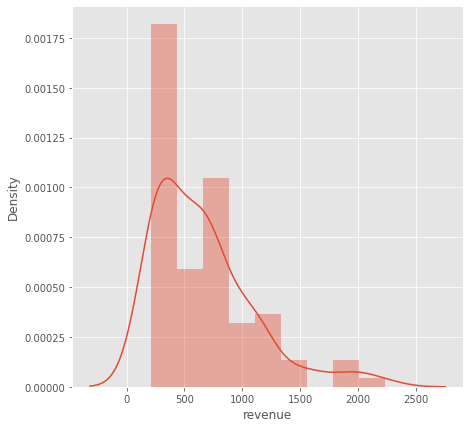

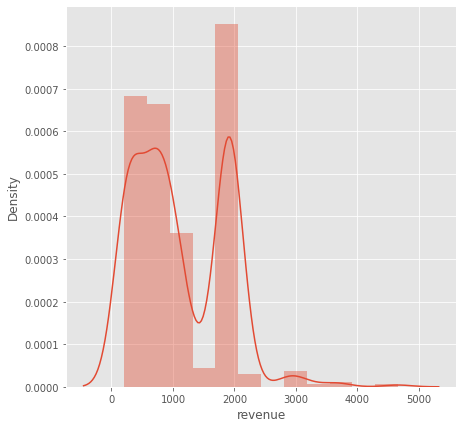

In [39]:
plt.figure(figsize=(7,7))
sns.distplot(control_t.revenue)

plt.figure(figsize=(7,7))
sns.distplot(test_t.revenue)

#### После удаления явных выбросов при применении повторно межквартильного способа выявления выбросов, естественно, появляются новые. Но без знания специфики бизнеса считаю неоправданным удаление дополнительных выбросов. Чтобы избежать потенциальной ошибки в принятии решения в этот раз произведу проверку на равенство средних и равнество распределений в группах и с выбросами и без. Если эксперимент даст диаметрально разные значения p-value - приму результаты полученные на данных без выбросов. В этом случае буду рекомендовать собрать больше данных для проведения отдельного теста с экстремально высокими значениями.

#### Создаю функцию для проверки распределений на нормальность:

In [11]:
def norm_test(serie):
    
    stat, p = scipy.stats.shapiro(serie)
    print('Statistics=%.3f, p-value=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        outcome = 'Принимаю гипотезу о нормальности'
    else:
        outcome = 'Отклоняю гипотезу о нормальности'
        
    return print(outcome)

#### Проверяю нормальность распределения в тестовой группе после удаления явных выбросов при помощи теста Шапиро-Уилка:

In [35]:
norm_test(test_t.revenue)

Statistics=0.868, p-value=0.000
Отклоняю гипотезу о нормальности


#### Проверяю нормальность распределения в контрольной группе после удаления явных выбросов при помощи теста Шапиро-Уилка:

In [36]:
norm_test(control_t.revenue)

Statistics=0.838, p-value=0.000
Отклоняю гипотезу о нормальности


#### Вывод: так как выборки достаточно малы и имеют распределение отличное от нормального - отказываюсь от применения метода t-Стьюдента, который, однако, дает максимально точный результат, учитывая и величину чека клиента.

#### Создаю функцию для проверки равномерности распределения данных в датасетах:

In [14]:
def uniformity(df1, df2):
    
    return print('Values distribution in the Control dataset:'), \
           print(df1['country'].agg([pd.Series.value_counts, lambda x: x.value_counts(normalize=True)])), \
           print(df1['platform'].agg([pd.Series.value_counts, lambda x: x.value_counts(normalize=True)])), \
           print(df1['sex'].agg([pd.Series.value_counts, lambda x: x.value_counts(normalize=True)])), \
           print(' \n '),\
           print('Values distribution in the Test dataset:'), \
           print(df2['country'].agg([pd.Series.value_counts, lambda x: x.value_counts(normalize=True)])), \
           print(df2['platform'].agg([pd.Series.value_counts, lambda x: x.value_counts(normalize=True)])), \
           print(df2['sex'].agg([pd.Series.value_counts, lambda x: x.value_counts(normalize=True)]))

uniformity(df_control, df_test)

Values distribution in the Control dataset:
        value_counts  <lambda>
Russia           915  0.594928
Sweden           623  0.405072
         value_counts  <lambda>
android           834  0.542263
ios               704  0.457737
        value_counts  <lambda>
male             785  0.510403
female           753  0.489597
 
 
Values distribution in the Test dataset:
        value_counts  <lambda>
Russia          4492  0.660297
Sweden          2311  0.339703
         value_counts  <lambda>
android          3787  0.556666
ios              3016  0.443334
        value_counts  <lambda>
male            3411  0.501396
female          3392  0.498604


(None, None, None, None, None, None, None, None, None)

#### Выводы: 

распределение значений в тестовом и контрольном датасетах достаточно равномерное;

так как количество данных в контрольной и тестовой выборках сильно отличаются а Манн-Уитни привередлив к дисбалансу в размерах выборок, что приводит в первую очередь к ослаблению мощности критерия (чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект)), то в качестве основного метода проверки гипотезы буду использовать Bootstrap, и только подкреплю результат исследованием при помощи метода Mанна Уитни;

несмотря на то что bootstrap проверяет равенство средних, а Манн Уитни проверяют равенство распределений, т.е. немного разные гипотезы, считаю это полезным.

#### Создаю функцию, которая позволит проверять гипотезы с помощью бутстрапа для оценки среднего значения:

In [15]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    return p_value

# Создаю функцию, которая позволит проверять гипотезы с помощью бутстрапа для оценки медианы:

def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
           
    return p_value

In [37]:
# Применяю bootstrap для проверки нулевой гипотезы о равенстве средних:

# Среднее значение на данных с выбросами:

mean_boo = get_bootstrap(df_control.query('revenue > 0').revenue, df_test.query('revenue > 0').revenue)

# Cреднее значение на данных без выбросов:

mean_boo_clean = get_bootstrap(control_t.query('revenue > 0').revenue, test_t.query('revenue > 0').revenue)

# Медианное значение на данных с выбросами:

median_boo = get_bootstrap_median(df_control.query('revenue > 0').revenue, df_test.query('revenue > 0').revenue)

# Медианное значение на данных без выбросов:

median_clean_boo = get_bootstrap_median(control_t.query('revenue > 0').revenue, test_t.query('revenue > 0').revenue)

# Применяю дополнительно критерий Манна-Уитни для того чтобы проверить нулевую гипотезу о равенстве распределений:
    
# С выбросами в тестовой группе: 

mann = mannwhitneyu(df_control.query('revenue > 0').revenue, df_test.query('revenue > 0').revenue)

# Без выбросов:

mann_clean = mannwhitneyu(control_t.revenue, test_t.revenue)

#### Вывожу результат в удобном виде:

In [38]:
print(f'Результат bootstrap теста: \
      \n Среднее значение на данных с выбросами:    {mean_boo}, \
      \n Cреднее значение на данных без выбросов:   {mean_boo_clean}, \
      \n Медианное значение на данных с выбросами:  {median_boo}, \
      \n Медианное значение на данных без выбросов: {median_clean_boo} \
        \n\nРезультат теста Манна Уитни:\n до удаления выбросов: {mann}) \
        \n после удаления выбросов: {mann_clean}')


Результат bootstrap теста:       
 Среднее значение на данных с выбросами:    1.0128606690050689e-06,       
 Cреднее значение на данных без выбросов:   2.609118851150089e-29,       
 Медианное значение на данных с выбросами:  0.0006159633614571726,       
 Медианное значение на данных без выбросов: 7.84898343823103e-17         

Результат теста Манна Уитни:
 до удаления выбросов: MannwhitneyuResult(statistic=17699.5, pvalue=0.0001364710277394854))         
 после удаления выбросов: MannwhitneyuResult(statistic=13849.0, pvalue=6.610452500811362e-08)


### Вывод:

С помощью бутстрапа я проверил нулевую гипотезу о равенстве средних, а при помощи теста Манна-Уитни 
гипотезу о равенстве распределений как на данных с выбросами, так и на очищенных данных. 

Несмотря на то что тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
Проведенные тесты дали значение p-value << 0.05, поэтому считаю что полученные в ходе эксперимента отличия являются статистически значимыми.

Несмотря на снижение конверсии активных пользователей в активных клиентов в покупку, revenue увеличилась на 392 413 у.е., ARPU вырос на 10.7 у.е., AOV вырос на 248.1 у.е.

C учетом доверительных интервалов принимаю решение рекомендовать выкатить изменения на всю аудиторию.

In [ ]:
#### Сценарий Advanced1: Проверяю гипотезу об изменениях в разрезе стран.

In [ ]:
# Сформирую более удобные для проверки датасеты:

nan = np.nan

# Разбиваю контрольную и тестовую группы по странам:

control_swe = df.query('country == "Sweden" & group == "A" & revenue > 0')

test_swe = df.query('country == "Sweden" & group == "B" & revenue > 0')

control_rus = df.query('country == "Russia" & group == "A" & revenue > 0')

test_rus = df.query('country == "Russia" & group == "B" & revenue > 0')

In [ ]:
# Смотрю основные параметры тесовой и контрольной групп из России:

datasets_params(control_rus, test_rus)

In [ ]:
# Смотрю основные параметры тесовой и контрольной групп из Швеции:

datasets_params(control_swe, test_swe)

In [ ]:
#### Проверю изменения основных параметров в контрольной и тестовой группах по странам:

In [ ]:
# Сравниваю изменения в контрольной и тестовой группах из России: 

before_after_params(control_rus, test_rus)

In [ ]:
# Сравниваю изменения в контрольной и тестовой группах из Швеции: 

before_after_params(control_swe, test_swe)

In [ ]:
# А эта функция - небольшая модификация функции before_after_params чтобы удобнее сравнить изменения по странам.

def params_change_by_country(control_rus, test_rus, control_swe, test_swe):
    
    # Сравниваю изменения в контрольной и тестовой группах из России: 

    Paying_conversion_cr = (100 * control_rus.agg({'revenue': 'count'})/control_rus.shape[0]).item()
    Revenue_cr = control_rus.revenue.sum()
    Revenue_mean_cr = control_rus.revenue.mean()
    Revenue_median_cr = control_rus.revenue.median()
    ARPU_cr = control_rus.revenue.sum()/control_rus.user_id.nunique()
    AOV_cr = control.revenue.sum()/control_rus.agg({'revenue': 'count'}).item()
    all_clients_cr = groups.query('group == "A"').shape[0]
    active_users_cr = control_rus.shape[0]
    paying_users_cr = control_rus.agg({'revenue': 'count'}).item()
    
    Paying_conversion_tr = (100* test_rus.agg({'revenue': 'count'})/test_rus.shape[0]).item()
    Revenue_tr = test_rus.revenue.sum()
    Revenue_mean_tr = test_rus.revenue.mean()
    Revenue_median_tr = test_rus.revenue.median()
    ARPU_tr =  test_rus.revenue.sum()/test_rus.shape[0]
    AOV_tr = test_rus.revenue.sum()/test_rus.agg({'revenue': 'count'}).item()
    all_clients_tr = groups.query('group == "B"').shape[0]
    active_users_tr = test_rus.shape[0]
    paying_users_tr = test_rus.agg({'revenue': 'count'}).item()


    # Сравниваю изменения в контрольной и тестовой группах из Швеции:   

    Paying_conversion_cs = (100 * control_swe.agg({'revenue': 'count'})/control_swe.shape[0]).item()
    Revenue_cs = control_swe.revenue.sum()
    Revenue_mean_cs = control_swe.revenue.mean()
    Revenue_median_cs = control_swe.revenue.median()
    ARPU_cs = control_swe.revenue.sum()/control_swe.user_id.nunique()
    AOV_cs = control_swe.revenue.sum()/control_swe.agg({'revenue': 'count'}).item()
    all_clients_cs = groups.query('group == "A"').shape[0]
    active_users_cs = control_swe.shape[0]
    paying_users_cs = control_swe.agg({'revenue': 'count'}).item()
    
    Paying_conversion_tw = (100* test_swe.agg({'revenue': 'count'})/test_swe.shape[0]).item()
    Revenue_tw = test_swe.revenue.sum()
    Revenue_mean_tw = test_swe.revenue.mean()
    Revenue_median_tw = test_swe.revenue.median()
    ARPU_tw = test_swe.revenue.sum()/test_swe.shape[0]
    AOV_tw = test_swe.revenue.sum()/test_swe.agg({'revenue': 'count'}).item()
    all_clients_tw = groups.query('group == "B"').shape[0]
    active_users_tw = test_swe.shape[0]
    paying_users_tw = test_swe.agg({'revenue': 'count'}).item()
    
    
    outcomes = {'Difference_rus': ['Paying conversion difference', Paying_conversion_tr - Paying_conversion_cr, 
                               'Revenue difference', Revenue_tr - Revenue_cr, 'ARPU difference', ARPU_tr - ARPU_cr, 
                               'AOV difference', AOV_tr - AOV_cr, 'Difference in number of users', all_clients_tr - all_clients_cr, 
                               'Active users difference', active_users_tr - active_users_cr,
                               'Revenue_mean_difference', Revenue_mean_tr - Revenue_mean_cr,
                               'Revenue_median_difference', Revenue_median_tr - Revenue_median_cr,
                               'Paying users difference', paying_users_tr - paying_users_cr],
                'Difference_swe': ['Paying conversion difference', Paying_conversion_tw - Paying_conversion_cs, 
                               'Revenue difference', Revenue_tw - Revenue_cs, 'ARPU difference', ARPU_tw - ARPU_cs, 
                               'AOV difference', AOV_tw - AOV_cs, 'Difference in number of users', all_clients_tw - all_clients_cs, 
                               'Active users difference', active_users_tw - active_users_cs,
                               'Revenue_mean_difference', Revenue_mean_tw - Revenue_mean_cs,
                               'Revenue_median_difference', Revenue_median_tw - Revenue_median_cs,
                               'Paying users difference', paying_users_tw - paying_users_cs],
               }
 
    return print(pd.DataFrame(outcomes))

params_change_by_country(control_rus, test_rus, control_swe, test_swe)

#### Задача 2:

Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, 
которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. 
Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью 
пользователей, и очень просит спроектировать ему дашборд.

Предложите метрики, которые помогли бы ему отслеживать вовлеченность пользователей и принимать 
оптимальные решения. Какую основную информацию вы бы отразили на дашборде? На какие метрики стоит 
обратить внимание в первую очередь? Почему?

#### Алгоритм решения:
Провожу интервью с руководителем и заинтересованными членами команды (в реальной ситуации). Составляю Dashboard Canvas.
Выбираю оптимальные метрики, прорабатываю макет дашборда. Согласовываю его с руководителем и членами команды.
Проектирую дашборд, готовлю тестовые задания для руководителя и членов команды по работе с дашбордом для того чтобы получить практическую обратную связь, произвести финальные доработки ориентируясь по обратной связи.
Договариваюсь о встрече с руководителем, делаю POC, собираю обратную связь. Дорабатываю дашборд.
Договариваюсь о том чтобы некоторое время понаблюдать "из-за спины" насколько руководителю удобно работать с дашбордом, получить инсайты и внести при возможности улучшения.
Договориться о периодичности встреч для адаптации дашборда к меняющимся потребносям руководителя и команды.

#### Выбор оптимальных метрик для решения задачи и описание дашборда:

Описание дашборда:
    
В левом верхнем углу руководитель сможет сразу же оценить ситуацию с текущим общим количеством пользователей и их распределением на активных пользователей и тех, кто приобрел приложение в текущем периоде.

Дальше по горизонтали идут показатели, которые имеют выражают финансовую вовлеченность клиентов. ARPPU и ARPU непосредственно связаны с вовлеченностью клиентов в использование продукта и чем они ближе по значению - тем более клиенты довольны самим приложением.

Далее идут 3 важных метрики дневной, недельной и месячной активности клиентов с динамикой изменения в соответствующих интервалах. Неизменно высокий DAU будет индикатором высокого интереса пользователей к Приложению, кроме того он поможет косвенно оценивать эффект от запуска рекламных компаний, WAU и MAU расскажут о стабильности интереса к Приложению.

Под ними расположены графики с:
    
retention клиентов тестирующих Приложение, который позволяет понять насколько гладко проходит тестирование и оперативно прийти на помощь клиенту в случае, если у него возникли проблемы с функционалом или просто напомнить ему о триальном периоде если его отвлекли от тестирования 
насущные дела;

классическим retention по месяцам, который показывает возвращаемость клиентов в Приложение после установки и поможет руководителю держать руку на пульсе.

Второй ряд виджетов помогает понять текущую ситуацию с конверсией из активных пользователей в клиентов, посмотреть динамику роста новых клиентов и визуально оценить конверсию из активных покупателей в клиентов а также при помощи фактоида stickness ratio понять как часто клиенты возвращаются в Приложение в течение месяца (период настраивается исходя из конкретных 
задач бизнеса).

Третий ряд виджетов помогает оценить вовлеченность клиентов через такую метрику как объем создаваемого контента в разбивке по фото и видео, оценить объем сгенерированного контента в разрезе стран, мобильных платформ и пола пользователей и видеть текущий показатель количества сессий и количества сессий на одного клиента  позволяет абстрагироваться от средней длины сессии и количества сессий и характеризует интерес пользователей к Приложению.

Четвертый ряд виджетов сконцентрирован на удовлетворенности клиентов Приложением, которая является важной частью вовлеченности.

Здесь руководитель сможет оперативно видеть как развивается комьюнити пользователей Приложения, видеть количество и тип коментариев, которые оставляют клиенты и таким образом видеть общий эмоциональный тренд. 
Важным виджетом в этой серии является ASL, который позволяет увидеть сколько времени пользователи находятся в Приложении и таким образом понять насколько интуитивно понятны UI и использование фичей Приложения (например, если у определенной части пользователей время сессии будет сильно расти - то  полезным будет провести дополнительное исследование и внести изменения в Продукт или оперативно оказать поддержку клиентам.

#### Поскольку в данных проекта (1 задание) отсутствует информация о времени событий, я спроектировал 2 дашборда и разместил шаблон дашборда со всеми метриками, которые считаю нужными в него включить по вот этой ссылке: 

https://disk.yandex.ru/i/KtcxTj_h5t8zzQ

#### Спасибо за внимание!